Continuous Solution
---

## 1. Import the Necessary Packages

In [1]:
from unityagents import UnityEnvironment

import gym
import random
import torch
import numpy as np
from collections import deque
from ddpg_agent import Agent
from itertools import count
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Instantiate the Environment and agent

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 3. Examine the State and Action Spaces

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 4. Take random actions in the environment

In [4]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.1254999971948564


## 5. Train the agent with DDPG

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=15)

def ddpg(n_episodes=200, print_every=10):
    scores_deque = deque(maxlen=print_every)
    scores_global = []
    average_global = []
    best_avg = -np.inf
    solved = False
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        
        score_average = 0
        for t in count():
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        score = np.mean(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        average_global.append(score_average)
                
        print('\rEpisode {}, Average Score: {:.2f}, Max Score: {:.2f}, Min Score: {:.2f}'\
              .format(i_episode, score_average, np.max(scores), np.min(scores)), end="\n")        
        
        if i_episode % print_every == 0:
            print('\tAverage Score: {:.2f}'.format(np.mean(scores_deque)), end="\n")  
            
        if score_average >= 30:
            if not solved:
                print('\nCongratulations! Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average))
                solved = True
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                    
     
    return scores_global, average_global

scores, averages = ddpg()

Episode 1, Average Score: 0.02, Max Score: 0.10, Min Score: 0.00
Episode 2, Average Score: 0.11, Max Score: 0.82, Min Score: 0.00
Episode 3, Average Score: 0.14, Max Score: 1.75, Min Score: 0.00
Episode 4, Average Score: 0.16, Max Score: 0.97, Min Score: 0.00
Episode 5, Average Score: 0.18, Max Score: 0.93, Min Score: 0.00
Episode 6, Average Score: 0.22, Max Score: 1.00, Min Score: 0.04
Episode 7, Average Score: 0.26, Max Score: 1.01, Min Score: 0.02
Episode 8, Average Score: 0.26, Max Score: 0.99, Min Score: 0.00
Episode 9, Average Score: 0.31, Max Score: 1.21, Min Score: 0.19
Episode 10, Average Score: 0.34, Max Score: 1.08, Min Score: 0.06
	Average Score: 0.34
Episode 11, Average Score: 0.41, Max Score: 1.54, Min Score: 0.22
Episode 12, Average Score: 0.46, Max Score: 1.30, Min Score: 0.00
Episode 13, Average Score: 0.54, Max Score: 3.03, Min Score: 0.26
Episode 14, Average Score: 0.63, Max Score: 1.97, Min Score: 0.22
Episode 15, Average Score: 0.73, Max Score: 2.63, Min Score: 0.3

Episode 118, Average Score: 39.24, Max Score: 39.63, Min Score: 36.52
Episode 119, Average Score: 39.24, Max Score: 39.65, Min Score: 38.41
Episode 120, Average Score: 39.24, Max Score: 39.65, Min Score: 38.39
	Average Score: 39.24
Episode 121, Average Score: 39.25, Max Score: 39.54, Min Score: 38.89
Episode 122, Average Score: 39.24, Max Score: 39.61, Min Score: 38.30
Episode 123, Average Score: 39.25, Max Score: 39.63, Min Score: 37.79
Episode 124, Average Score: 39.21, Max Score: 39.56, Min Score: 34.82
Episode 125, Average Score: 39.20, Max Score: 39.62, Min Score: 36.54
Episode 126, Average Score: 39.19, Max Score: 39.62, Min Score: 38.28
Episode 127, Average Score: 39.16, Max Score: 39.63, Min Score: 36.65
Episode 128, Average Score: 39.16, Max Score: 39.62, Min Score: 38.08
Episode 129, Average Score: 39.15, Max Score: 39.62, Min Score: 37.82
Episode 130, Average Score: 39.12, Max Score: 39.64, Min Score: 36.89
	Average Score: 39.12
Episode 131, Average Score: 39.08, Max Score: 

## 6. Plot the scores

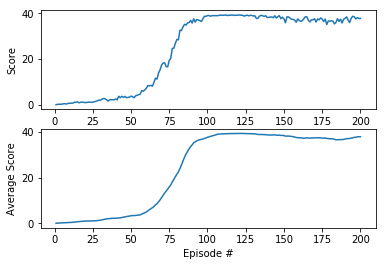

In [6]:
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, len(scores)+1), averages)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

## 7. Test agent

In [7]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 33.93899924140423


## 8. Close the environment

In [8]:
env.close()